# Modeling and Simulation in Python

Chapter 9: Projectiles

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


We'll start with the same code we saw last time: the magic command that tells Jupyter where to put the figures, and the import statement that gets the function defined in the `modsim` module.

In [1]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt|

# tempo switch from one to another, you have to select Kernel->Restart

%matplotlib notebook

from modsim import *

In [2]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram

In [3]:
init = State(y=381 * m, 
             v=0 * m/s)
init

,value
y,381 meter
v,0.0 meter / second


In [4]:
ts = linrange(0, 10, 1)

In [5]:
g = 9.8 * m/s**2
system = System(init=init, g=g, ts=ts)

In [6]:
def slope_func(state, t, system):
    y, v = state
    unpack(system)    

    dydt = v
    dvdt = -g
    
    return dydt, dvdt

In [7]:
state = slope_func(init, 0, system)
state

(<Quantity(0.0, 'meter / second')>, <Quantity(-9.8, 'meter / second ** 2')>)

In [8]:
run_odeint(system, slope_func)

In [9]:
system.results.head()

,y,v
0.0,381.0,0.0
1.0,376.1,-9.8
2.0,361.4,-19.6
3.0,336.9,-29.4
4.0,302.6,-39.2


In [10]:
system.results.tail()

,y,v
6.0,204.6,-58.8
7.0,140.9,-68.6
8.0,67.4,-78.4
9.0,-15.9,-88.2
10.0,-109.0,-98.0


In [11]:
def final_state(system):
    t_end = system.results.index[-1]
    y, v = system.results.loc[t_end]
    return y*m, v*m/s

In [12]:
y_final, v_final = final_state(system)
v_final

<Quantity(-98.00000000000003, 'meter / second')>

In [13]:
km = UNITS.kilometer
h = UNITS.hour
v_final.to(km / h)

<Quantity(-352.8000000000001, 'kilometer / hour')>

In [14]:
def plot_results(results):
    newfig()
    plot(results.y, label='y')
    if hasattr(results, 'x'):
        plot(results.x, label='x')
        
    decorate(xlabel='Time (s)',
             ylabel='Position (m)')

<IPython.core.display.Javascript object>


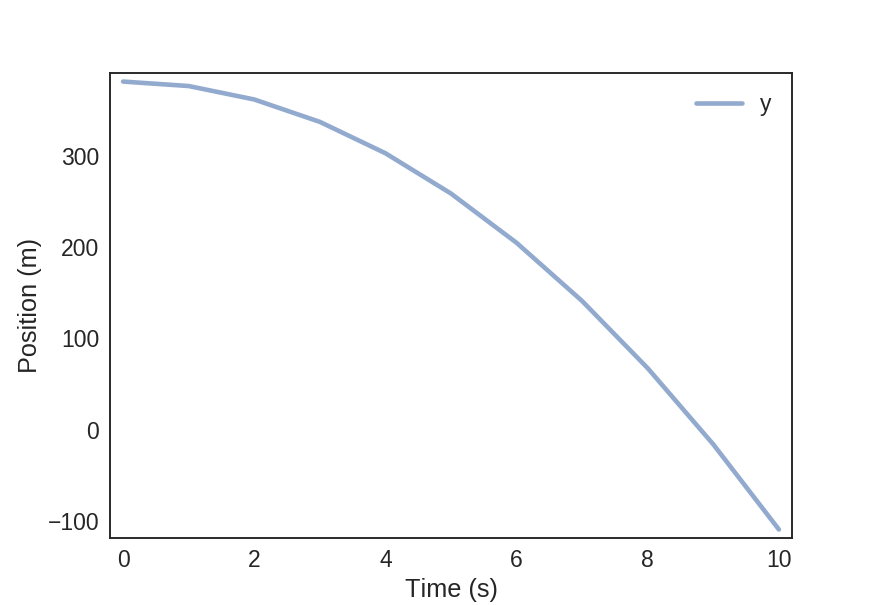

In [15]:
plot_results(system.results)

In [16]:
def make_system(duration):
    init = State(y=381 * m, v=0 * m/s)

    g = 9.8 * m/s**2
    ts = linspace(0, duration, 101)
    return System(init=init, g=g, ts=ts)

In [17]:
def height_func(duration):
    
    system = make_system(duration)
    run_odeint(system, slope_func)
    
    y_final, v_final = final_state(system)    
    return y_final

In [18]:
height_func(10)

<Quantity(-109.00000000074522, 'meter')>

In [19]:
t_final = fsolve(height_func, 10)
t_final

array([ 8.81788535])

In [20]:
system = make_system(t_final)
run_odeint(system, slope_func)
y_final, v_final = final_state(system)    
y_final

<Quantity(-1.7053025658242404e-13, 'meter')>

In [21]:
v_final

<Quantity(-86.41527642718769, 'meter / second')>

In [22]:
v_final.to(km / h)

<Quantity(-311.0949951378757, 'kilometer / hour')>

https://en.wikipedia.org/wiki/Drag_equation

In [23]:
condition = Condition(height = 381 * m,
                      g = 9.8 * m/s**2,
                      mass = 2.5e-3 * kg,
                      diameter = 19e-3 * m,
                      rho = 1.2 * kg/m**3,
                      v_term = 20 * m / s,
                      duration = 20)

In [24]:
def make_system(condition):
    unpack(condition)
    
    init = State(y=height, v=0 * m/s)

    area = np.pi * (diameter/2)**2
    c_d = 2 * mass * g / (rho * area * v_term**2)

    ts = linspace(0, duration, 101)
    
    return System(init=init, g=g, c_d=c_d, rho=rho,
                  mass=mass, area=area, ts=ts)

In [25]:
system = make_system(condition)
system

,value
init,y 381 meter v 0.0 meter / secon...
g,9.8 meter / second ** 2
c_d,0.3600458084719701 dimensionless
rho,1.2 kilogram / meter ** 3
mass,0.0025 kilogram
area,0.0002835287369864788 meter ** 2
ts,"[0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, ..."


In [26]:
def slope_func(state, t, system):
    y, v = state
    unpack(system)
    
    f_drag = rho * v**2 * c_d * area / 2
    a_drag = f_drag / mass
    
    dydt = v
    dvdt = -g + a_drag
    
    return dydt, dvdt

In [27]:
slope_func(system.init, 0, system)

(<Quantity(0.0, 'meter / second')>, <Quantity(-9.8, 'meter / second ** 2')>)

In [28]:
run_odeint(system, slope_func)

In [29]:
final_state(system)

(<Quantity(9.291723194256402, 'meter')>,
 <Quantity(-19.999999876925475, 'meter / second')>)

In [30]:
def height_func(duration, condition):
    
    condition.set(duration=duration)
    system = make_system(condition)
    
    run_odeint(system, slope_func)
    
    y_final, v_final = final_state(system)
    
    return y_final

In [31]:
height_func(20, condition)

<Quantity(9.291723194256402, 'meter')>

In [32]:
solution = fsolve(height_func, 20, condition)
solution

array([ 20.46458616])

In [33]:
condition.set(duration=solution)
system = make_system(condition)
run_odeint(system, slope_func)
y_final, v_final = final_state(system)

In [34]:
y_final, v_final

(<Quantity(-3.2596148002994596e-13, 'meter')>,
 <Quantity(-19.999999919652346, 'meter / second')>)

<IPython.core.display.Javascript object>


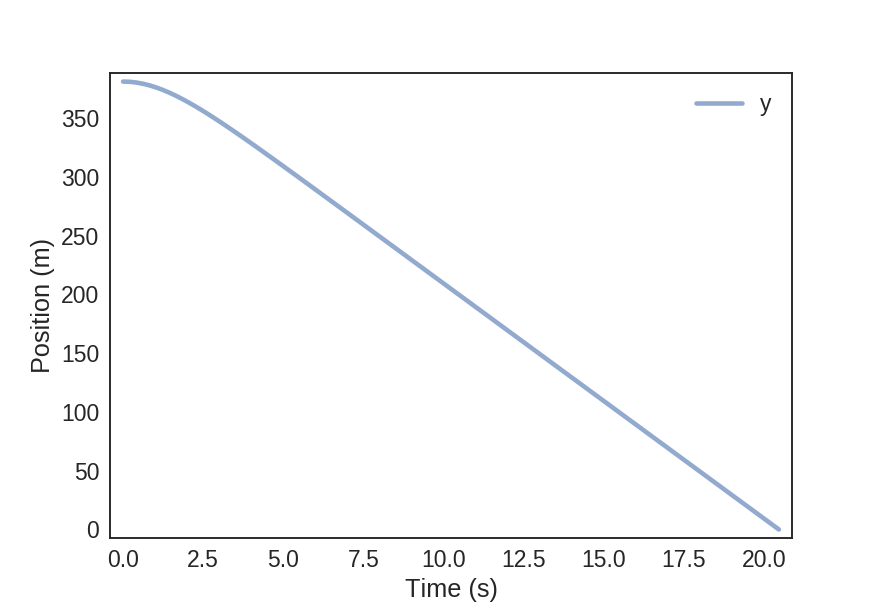

In [35]:
plot_results(system.results)

In [36]:
degree = UNITS.degree

angle = 45 * degree
angle

<Quantity(45, 'degree')>

In [37]:
angle.to(UNITS.radian)

<Quantity(0.7853981633974483, 'radian')>

In [38]:
condition = Condition(g = 9.8 * m/s**2,
                      mass = 145e-3 * kg,
                      diameter = 73e-3 * m,
                      rho = 1.2 * kg/m**3,
                      c_d = 0.3,
                      angle = 45 * degree,
                      velocity = 40 * m / s,
                      duration = 5)

In [39]:
def make_system(condition):
    unpack(condition)
    
    x, y = 0 * m, 0 * m
    theta = np.deg2rad(angle)
    vx, vy = pol2cart(theta, velocity)
    init = State(x=x, y=y, vx=vx, vy=vy)
    
    area = np.pi * (diameter/2)**2
    ts = linspace(0, duration, 101)
    
    return System(init=init, g=g, mass=mass, 
                  area=area, rho=rho, c_d=c_d, ts=ts)

In [40]:
system = make_system(condition)
system.init

,value
x,0 meter
y,0 meter
vx,28.284271247461902 meter / second
vy,28.2842712474619 meter / second


In [41]:
def slope_func(state, t, system):
    x, y, vx, vy = state
    unpack(system)
    
    grav = Vector(0, -g)

    v = Vector(vx, vy)
    f_drag = -rho * v.mag**2 * c_d * area / 2 * v.hat()
    a_drag = f_drag / mass
    
    a = grav + a_drag
    
    return v.x, v.y, a.x, a.y

In [42]:
slope_func(system.init, 0, system)

(28.284271247461902,
 28.284271247461898,
 -5.8782098923314043,
 -15.678209892331406)

In [43]:
run_odeint(system, slope_func)

In [44]:
system.results.head()

,x,y,vx,vy
0.00,0.000000,0.000000,28.284271,28.284271
0.05,1.406937,1.394729,27.994631,27.507136
0.10,2.799602,2.750933,27.713310,26.743173
0.15,4.178402,4.069257,27.439988,25.991831
0.20,5.543729,5.350318,27.174360,25.252590


In [45]:
system.results.tail()

,x,y,vx,vy
4.80,98.812253,4.596677,15.332981,-20.667500
4.85,99.576338,3.554536,15.230379,-21.017559
4.90,100.335288,2.494981,15.127592,-21.364058
4.95,101.089094,1.418190,15.024633,-21.706981
5.00,101.837749,0.324343,14.921515,-22.046315


In [46]:
xs = system.results.x
ys = system.results.y

<IPython.core.display.Javascript object>


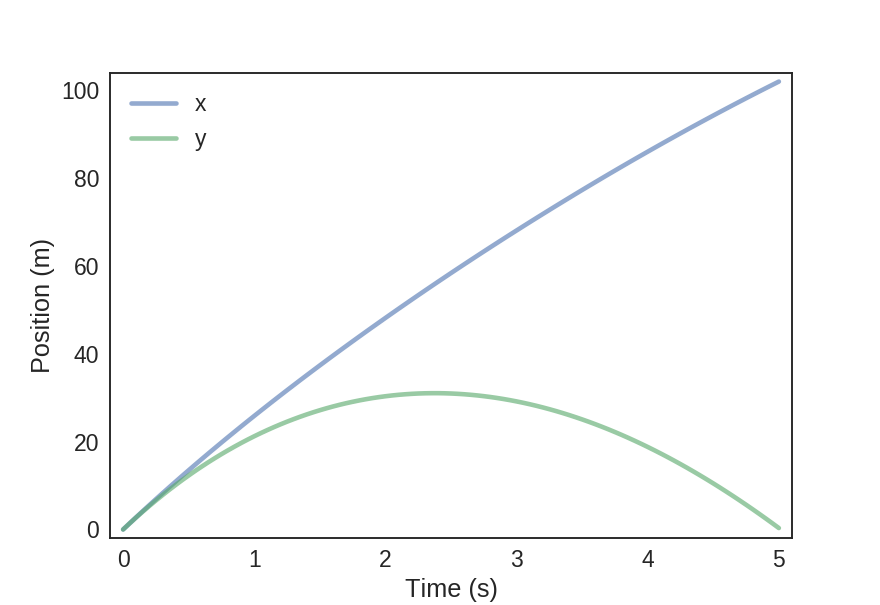

In [47]:
newfig()
plot(xs, label='x')
plot(ys, label='y')

decorate(xlabel='Time (s)',
         ylabel='Position (m)')

<IPython.core.display.Javascript object>


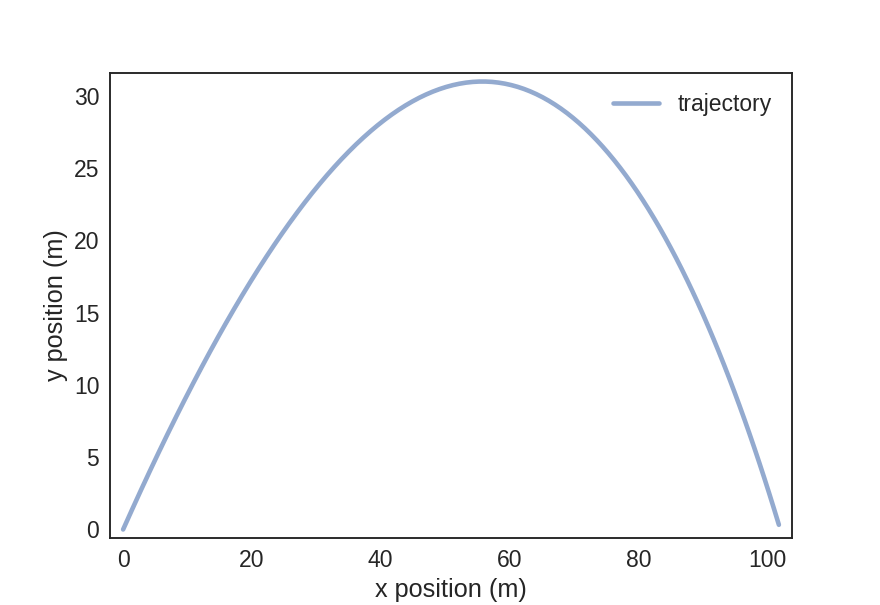

In [48]:
newfig()
plot(xs, ys, label='trajectory')

decorate(xlabel='x position (m)',
         ylabel='y position (m)')

<IPython.core.display.Javascript object>


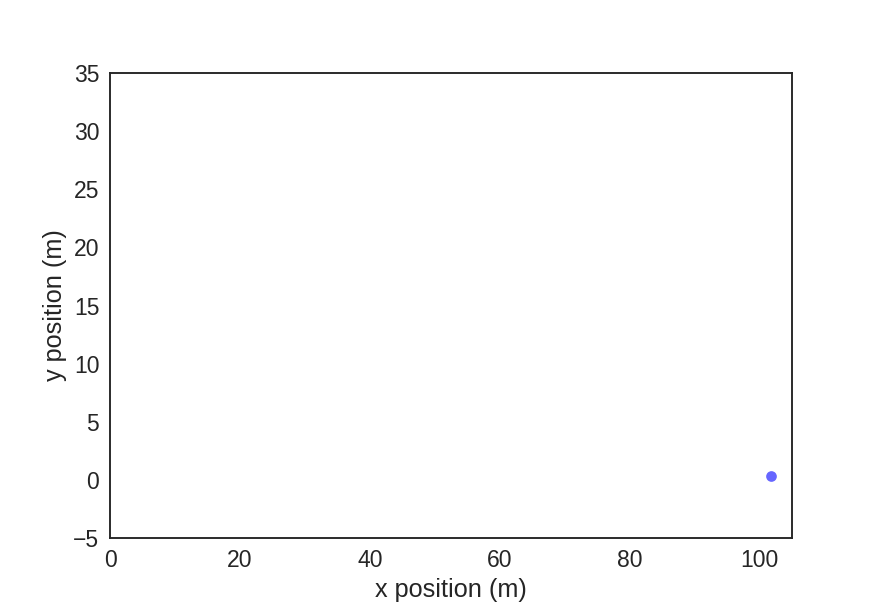

In [49]:
newfig()
decorate(xlabel='x position (m)',
         ylabel='y position (m)',
         xlim=[0, 105],
         ylim=[-5, 35],
         legend=False)

for x, y in zip(xs, ys):
    plot(x, y, 'bo', update=True)
    sleep(0.01)

In [50]:
def animate2d(xs, ys, speedup=1):
    ts = xs.index
    dts = np.diff(ts)
    dts = np.append(dts, 0)

    newfig()
    decorate(xlabel='x position (m)',
             ylabel='y position (m)',
             xlim=[xs.min(), xs.max()],
             ylim=[ys.min(), ys.max()],
             legend=False)

    for x, y, dt in zip(xs, ys, dts):
        plot(x, y, 'bo', update=True)
        sleep(dt / speedup)

In [51]:
# animate2d(system.results.x, system.results.y)

In [52]:
def final_state(system):
    t_end = system.results.index[-1]
    y, v = system.results.loc[t_end]
    return y*m, v*m/s

In [53]:
def height_func(duration, condition):
    
    condition.set(duration=duration)
    
    system = make_system(condition)
    
    run_odeint(system, slope_func)
    
    t_end = system.results.index[-1]
    y_final = system.results.y[t_end]
    
    return y_final

In [54]:
height_func(5, condition)

0.32434254940713858

In [55]:
%time solution = fsolve(height_func, 5, condition, xtol=1e-2)
solution

CPU times: user 1.35 s, sys: 8 ms, total: 1.36 s
Wall time: 1.36 s


array([ 5.01471192])

In [56]:
condition = Condition(g = 9.8,
                      mass = 145e-3,
                      diameter = 73e-3,
                      rho = 1.2,
                      c_d = 0.3,
                      angle = 45,
                      velocity = 40,
                      duration = 5)

In [57]:
height_func(5, condition)

0.32434254940713858

In [58]:
%time solution = fsolve(height_func, 5, condition, xtol=1e-2)
solution

CPU times: user 160 ms, sys: 0 ns, total: 160 ms
Wall time: 160 ms


array([ 5.01471192])

In [59]:
def final_range(results):
    return results.x.iloc[-1]

In [60]:
condition.set(duration=solution)
    
system = make_system(condition)
    
run_odeint(system, slope_func)
final_range(system.results)

102.05704922717666

In [61]:
def range_func(angle, condition):
    print(angle)
    
    if angle < 0 or angle > 90:
        raise ValueError('Invalid angle: %s' % angle)
    
    condition.set(angle=angle)
    solution = fsolve(height_func, 5, condition, xtol=1e-2)
    
    condition.set(duration=solution)
    system = make_system(condition)
    
    run_odeint(system, slope_func)
    
    x_final = final_range(system.results)
    #print(x_final)
    return -x_final


In [62]:
angle = 40
range_func(angle, condition)

40


-102.62291869022413

In [63]:
condition.set(c_d=0.7)

In [64]:
from scipy.optimize import minimize_scalar

In [65]:
args = (condition,)
options = dict(xatol=1e-3)
res = minimize_scalar(range_func, [10, 80], bounds=[0, 90], args=args, 
                method='bounded', options=options)

34.3769410125
55.6230589875
21.246117975
39.442163351
38.93760905
38.8134975901
38.8011400696
38.8014739785
38.8008061608
37.1110400358
38.1553729341
38.5542726056
38.7066387221
38.7648373998
38.7870673166
38.7955583893
38.7988016904
38.8000405212
38.8004722519


In [66]:
res.x

38.800472251929683